# Thesis Code : Smart Slicing through Deep Reinforcement Learning

## Insall the Packages and Dependencies

In [1]:
#import hydra
from omegaconf import DictConfig, OmegaConf, open_dict
from pathlib import Path
from datetime import datetime
import torch
from hydra import compose, initialize_config_dir
#from sfc_rl.cli import main

overrides_list = [
    "data.v_sim_setting.num_groups=4",
    "data.v_sim_setting.num_v_nets=4",
    "model.dqn.eps_decay_steps=10000",
    "train.run_in_notebook=true",
    "eval.enabled=true",
    "train.train=false",
    "model.dqn.batch_size=32",
    "model.dqn.buffer_size=1000",
    "train.save_every=50",
    "eval.policies.2.name=exhaustive",
    "project_name=Train-CrossValidation0"
]

with initialize_config_dir(version_base=None, config_dir="/home/mehrab/Workspaces/Thesis-Smart-Slicing-rl-revised/config"):
    # Pass the list of overrides to the 'overrides' argument
    cfg = compose(config_name="experiment", overrides=overrides_list)

cfg

/home/mehrab/virne/lib/python3.12/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'experiment': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


{'data': {'p_net_setting': {'dataset_dir': '', 'topology': {'type': 'erdos_renyi', 'num_nodes': 5, 'p': 1}, 'node_attrs_setting': [{'name': 'cpu', 'distribution': 'uniform', 'dtype': 'float', 'low': 8, 'high': 16}], 'link_attrs_setting': [{'name': 'bandwidth', 'distribution': 'uniform', 'dtype': 'float', 'low': 768, 'high': 1280}, {'name': 'delay', 'distribution': 'uniform', 'dtype': 'float', 'low': 10, 'high': 20}], 'output': {'if_save': True, 'save_dir': 'datasets/p_net'}}, 'v_sim_setting': {'num_v_nets': 4, 'num_groups': 2, 'cache_size': '${data.v_sim_setting.num_v_nets}', 'cache_path': '.vnReqs_cache', 'sfc_len': {'low': 5, 'high': 5, 'distribution': 'uniform'}, 'vnf_types': ['fw', 'nat', 'ids', 'wanopt'], 'node_attrs_setting': [{'name': 'cpu', 'distribution': 'uniform', 'dtype': 'float', 'low': 0, 'high': 0}], 'qos_attrs_setting': [{'name': 'bandwidth', 'distribution': 'uniform', 'dtype': 'float', 'low': 16, 'high': 256}, {'name': 'latency', 'distribution': 'uniform', 'dtype': 'fl

In [2]:
#!python main(cfg) project_name=First_colab_run -> i cant run it since i pass cfg directly to main
#from sfc_rl.cli import main
#main(cfg)

In [3]:
import hydra
from omegaconf import DictConfig, OmegaConf, open_dict
from pathlib import Path
from datetime import datetime
import torch
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import time
import shutil
import re

from sfc_rl.data.dataset_provider import DatasetProvider
from sfc_rl.data.dataset_generator import Generator
from sfc_rl.env.sfc_env import SFCEnvRevised
from sfc_rl.env.state_encoders import NormalizedStateEncoder
from sfc_rl.env.action_space import NodeSelectionActionSpace
from sfc_rl.env.reward import QoE_QoS_Reward
from sfc_rl.env.qoe import QoE_QoS_PaperModel
from sfc_rl.models.dqn import DQNPolicy
from sfc_rl.models.networks import MLPPolicyNetwork
from sfc_rl.models.replay_buffer import ReplayBuffer
from sfc_rl.baselines.random_policy import RandomPolicy
from sfc_rl.baselines.exhaustive_solver import ExhaustiveSolver
#from sfc_rl.train.trainer import TrainerRevised
from sfc_rl.train.evaluator import Evaluator
from sfc_rl.utils.seed import set_seed
from sfc_rl.utils.logging import setup_logger
from sfc_rl.utils.tensorboard import launch_tensorboard

## Config Preparation


In [4]:

    # Set seed
    seed = cfg.get("seed", 42)
    set_seed(seed)

    # Create output directory
    output_dir = Path(f"{cfg.get('output_dir', 'outputs')}/{cfg.get('project_name', 'Ciriaa')}_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
    output_dir.mkdir(parents=True, exist_ok=True)
    # Setup logger
    logger = setup_logger("sfc_rl_test_data", log_file=output_dir / "run.log")
    logger.info(f"Starting experiment with config:\n{OmegaConf.to_yaml(cfg)}")

    # Save config
    OmegaConf.save(cfg, output_dir / "config.yaml")

    # Load dataset
    # Merge data config into main config for Generator
    # When using Hydra defaults, cfg.data contains the merged config from data/synthetic_small.yaml
    with open_dict(cfg):
        if 'p_net_setting' not in cfg:
            # Check if p_net_setting is in cfg.data (from Hydra defaults)
            if hasattr(cfg, 'data') and cfg.data is not None:
                if hasattr(cfg.data, 'p_net_setting') and cfg.data.p_net_setting is not None:
                    cfg.p_net_setting = cfg.data.p_net_setting
                elif hasattr(cfg.data, 'get') and cfg.data.get('p_net_setting') is not None:
                    cfg.p_net_setting = cfg.data.get('p_net_setting')

        if 'v_sim_setting' not in cfg:
            # Check if v_sim_setting is in cfg.data (from Hydra defaults)
            if hasattr(cfg, 'data') and cfg.data is not None:
                if hasattr(cfg.data, 'v_sim_setting') and cfg.data.v_sim_setting is not None:
                    cfg.v_sim_setting = cfg.data.v_sim_setting
                elif hasattr(cfg.data, 'get') and cfg.data.get('v_sim_setting') is not None:
                    cfg.v_sim_setting = cfg.data.get('v_sim_setting')




INFO     17:53:22 [sfc_rl_test_data] Starting experiment with config:
data:
  p_net_setting:
    dataset_dir: ''
    topology:
      type: erdos_renyi
      num_nodes: 5
      p: 1
    node_attrs_setting:
    - name: cpu
      distribution: uniform
      dtype: float
      low: 8
      high: 16
    link_attrs_setting:
    - name: bandwidth
      distribution: uniform
      dtype: float
      low: 768
      high: 1280
    - name: delay
      distribution: uniform
      dtype: float
      low: 10
      high: 20
    output:
      if_save: true
      save_dir: datasets/p_net
  v_sim_setting:
    num_v_nets: 4
    num_groups: 2
    cache_size: ${data.v_sim_setting.num_v_nets}
    cache_path: .vnReqs_cache
    sfc_len:
      low: 5
      high: 5
      distribution: uniform
    vnf_types:
    - fw
    - nat
    - ids
    - wanopt
    node_attrs_setting:
    - name: cpu
      distribution: uniform
      dtype: float
      low: 0
      high: 0
    qos_attrs_setting:
    - name: bandwidth
      

## Dataset

In [5]:

    # Create dataset provider
    dataset_provider = DatasetProvider(cfg, logger)
    cache_path = Path(cfg.data.v_sim_setting.get('cache_path', '.vnReqs_cache'))

    if cache_path.exists() and cache_path.is_dir():
        shutil.rmtree(cache_path)
        logger.info(f"Cleaned and removed cache: {cache_path}")

    pn = dataset_provider.get_physical_network()
    vn_requests = dataset_provider.get_vn_requests()
    flag_pn = cfg.data.p_net_setting.get('dataset_dir',None) is not None
    flag_vn = cfg.data.v_sim_setting.get('dataset_dir',None) is not None
    logger.info(f"PN with {len(pn.nodes)} nodes and {len(pn.links)} links {'Loaded from path ' if flag_pn else 'Generated' }")
    logger.info(f" {len(vn_requests)} VN requests {'Loaded from path ' if flag_vn else 'Generated' }")

    if cfg.get('End_phase','All') == 'data' :
        if cache_path.exists() and cache_path.is_dir():
            shutil.rmtree(cache_path)
            logger.info(f"Cleaned and removed cache: {cache_path}")
        else:
            logger.info(f"Cache directory not found: {cache_path}")

        logger.info(f"Finishied---Dont proceed")


INFO     17:53:22 [sfc_rl_test_data] Cleaned and removed cache: .vnReqs_cache
INFO     17:53:23 [sfc_rl_test_data] PN with 5 nodes and 10 links Loaded from path 
INFO     17:53:23 [sfc_rl_test_data]  8 VN requests Generated


## Environment

In [6]:

    #------------------------------- Env------------------------------------

    num_groups = cfg.data.v_sim_setting.get('num_groups')

    # Create environment components
    env_cfg = cfg.env

    # State encoder
    state_encoder_type = env_cfg.state.get("encoder", "NormalizedStateEncoder")
    if state_encoder_type == "NormalizedStateEncoder":
        state_encoder = NormalizedStateEncoder(env_cfg.state.get("encoder_config", {}))
    else:
        raise ValueError(f"Unknown encoder type: {state_encoder_type}")
    state_dim = state_encoder.get_state_dim(pn)

    # Action space
    action_space = NodeSelectionActionSpace(
        mask_illegal=env_cfg.action.get("mask_illegal", True)
    )
    action_dim = action_space.get_action_dim(pn)

    # QoE model
    qoe_cfg = env_cfg.qoe_model
    if qoe_cfg.name == "qoe_qos_paper":
        qoe_model = QoE_QoS_PaperModel(qoe_cfg.get("config", {}))
    else:
        raise ValueError(f"Unknown QoE model: {qoe_cfg.name}")

    # Reward function
    #reward_fn = TerminalQoEReward(qoe_model, env_cfg.reward)
    reward_fn = QoE_QoS_Reward(qoe_model, env_cfg.reward)

    # Create environment
    env = SFCEnvRevised(
        pn=pn,
        vn_requests=vn_requests,
        num_groups=num_groups,
        state_encoder=state_encoder,
        action_space=action_space,
        reward_fn=reward_fn,
        qoe_model=qoe_model,
        max_steps_per_request=cfg.train.get("max_steps_per_episode", 2000),
    )





## Policy

In [7]:

    #------------------------------------- Policy --------------------------------


    # Create policy
    model_cfg = cfg.model
    if model_cfg.type == "dqn":

        # Create network
        network_cfg = model_cfg.network
        network = MLPPolicyNetwork(
            state_dim=state_dim,
            action_dim=action_dim,
            hidden_sizes=network_cfg.hidden_sizes,
            activation=network_cfg.activation,
            dueling=model_cfg.dqn.get("dueling", False),
        )

        # Create DQN policy
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        policy = DQNPolicy(
            state_dim=state_dim,
            action_dim=action_dim,
            network=network,
            config=model_cfg,
            device=device,
        )
        logger.info(f"Created DQN policy on {device}")
    elif model_cfg.type == "random":
        policy = RandomPolicy(cfg.get("seed", 42))
    elif model_cfg.type == 'Violent':
        policy = ExhaustiveSolver( max_embeddings=1000000, seed = cfg.get("seed", 42))
    else:
        raise ValueError(f"Unknown model type: {model_cfg.type}")




INFO     17:53:40 [sfc_rl_test_data] Created DQN policy on cuda


## Train

In [8]:
#------------------------------------- Train -----------------------------------------

from scipy import interpolate
from sfc_rl.train.plots import plot_training_curves

tensorboard_use = False

if tensorboard_use:

    tb_writer = SummaryWriter(log_dir=str(output_dir / "tensorboard"))
    tb_process = launch_tensorboard(output_dir / "tensorboard")
    logger.info("launching Tensorboard...")

    time.sleep(5)


num_trains = 4
grps_permutation_seeds = np.random.randint(1,50,num_trains).tolist()
grps_permutation_seeds[0]= None

RESULTS = []
LOSSES = []

# Train
train_cfg = cfg.train
if train_cfg.get('train', True): #or getattr(train_cfg, 'train', True):

    for tr in range(num_trains):
        env.grps_permutation_seed = grps_permutation_seeds[tr]
        policy.refresh()

        trainer = TrainerRevised(
            env=env,
            policy=policy,
            config=train_cfg,
            output_dir=output_dir,
            summarywriter=tb_writer if tensorboard_use else None,
            logger=logger,
            tensorboard_use=tensorboard_use,
        )

        logger.info(f"Starting training loop {tr + 1}...")
        results, losses = trainer.train()

        for i in results.keys():
            if 'mean_episode_length' in results[i]:
                del results[i]['mean_episode_length']

        print(f'{'#\n' * 10}')
        logger.info(f"Training completed. Final metrics:")
        for episode, metric in results.items():
            #print(f'Episode {episode}: {metric} \n' )
            logger.info(f'Episode {episode}: {metric} \n')
        qoes=[results[i]['qoe'] for i in results.keys()]
        RESULTS.append(qoes)
        LOSSES.append(losses)


    averaged_qoes = np.mean(RESULTS, axis=0)
    loss_interpolated = []

    num_episodes = len(RESULTS[0])
    resolution_loss =  np.max([len(loss) for loss in LOSSES])
    print('loss_interpolated: ',resolution_loss)

    x_arrays = [np.linspace(0,num_episodes,len(loss)) for loss in LOSSES]
    x_common_loss = np.linspace(0, num_episodes , resolution_loss)  # Higher resolution than any input

    # Interpolate each dataset to common grid
    y_interpolated = []
    for x_orig, loss_orig in zip(x_arrays, LOSSES):
        # Create interpolation function
        interp_func = interpolate.interp1d(
            x_orig, loss_orig,
            kind='linear',  # or 'cubic', 'quadratic'
            bounds_error=False,
            fill_value='extrapolate'  # or specific value
        )
        # Evaluate on common grid
        loss_interpolated.append(interp_func(x_common_loss))

    # Average the interpolated values
    loss_avg = np.mean(loss_interpolated, axis=0)
    loss_std = np.std(loss_interpolated, axis=0)  # Optional: standard deviation





    plot_training_curves(rewards=averaged_qoes, losses= loss_avg,output_dir = output_dir / "training plots", filename=f"averaged_QoE_Loss_for_{num_trains}-time-training.png", window=5,episode=num_episodes,run_in_notebook=train_cfg.run_in_notebook)


else:
    logger.info("training Skipped...")



INFO     17:53:44 [sfc_rl_test_data] training Skipped...


## Loading best model

## Evaluate

INFO     17:53:44 [sfc_rl_test_data] Starting Evaluating...
INFO     17:53:44 [sfc_rl_test_data] Evaluating policy: random


Evaluating random policy :   0%|                          | 0/2 [00:00<?, ?it/s]

group id 0 --> group id 0
vn_requests[0:4]
request id: 0 of group 0 failed with reward -10.0
request id: 1 of group 0 failed with reward -10.0
request id: 2 of group 0 embedded with reward 2.733918379282249
request id: 3 of group 0 failed with reward -10.0
group id 1 --> group id 1
vn_requests[4:8]
request id: 0 of group 1 failed with reward -10.0
request id: 1 of group 1 failed with reward -10.0
request id: 2 of group 1 failed with reward -10.0


Evaluating random policy : 100%|██████████████████| 2/2 [00:00<00:00, 13.40it/s]

request id: 3 of group 1 failed with reward -10.0
INFO     17:53:44 [sfc_rl_test_data] Evaluating policy: violent



Evaluating violent policy :   0%|                         | 0/2 [00:00<?, ?it/s]

group id 0 --> group id 0
vn_requests[0:4]
request id: 0 of group 0 embedded with reward 3.7365097544114714
request id: 1 of group 0 embedded with reward 3.8904911373795508
request id: 2 of group 0 embedded with reward 3.1150422827112183


Evaluating violent policy :  50%|████████▌        | 1/2 [00:08<00:08,  8.33s/it]

request id: 3 of group 0 failed with reward -10.0
group id 1 --> group id 1
vn_requests[4:8]
request id: 0 of group 1 embedded with reward 4.213368071448865
request id: 1 of group 1 failed with reward -10.0
request id: 2 of group 1 embedded with reward 3.198364201163017


Evaluating violent policy : 100%|█████████████████| 2/2 [00:18<00:00,  9.01s/it]

request id: 3 of group 1 embedded with reward 3.7262413930635607
reward: {'random': {0: np.float64(-6.816520405179438), 1: np.float64(-8.40826020258972)}, 'violent': {0: np.float64(0.18551079362556022), 1: np.float64(0.23500210502221042)}}
qoe: {'random': {1: 0.0}, 'violent': {1: np.float64(3.8904911373795508)}}
accp: {'random': {0: 0.25, 1: 0.0}, 'violent': {0: 0.75, 1: 0.75}}


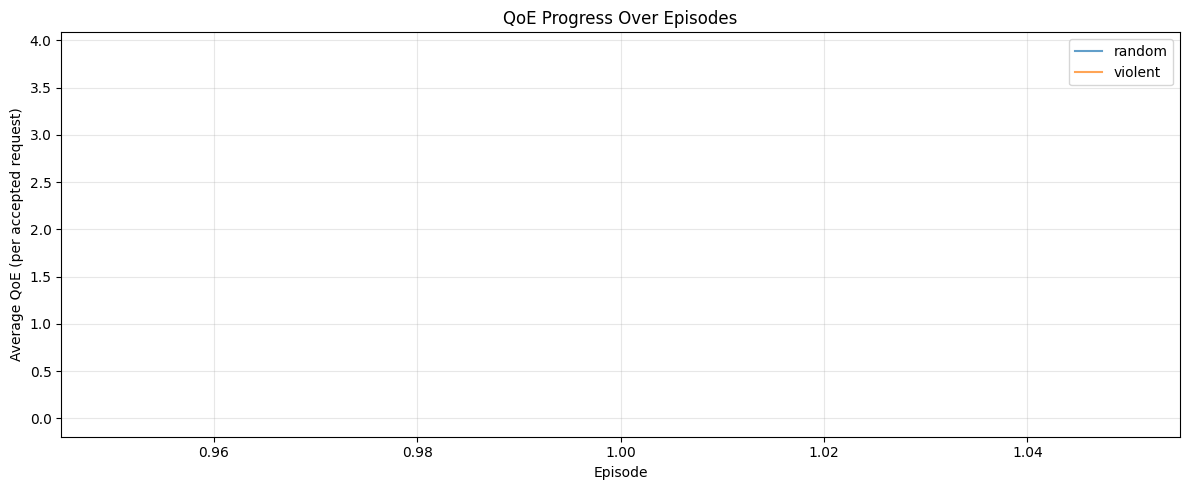

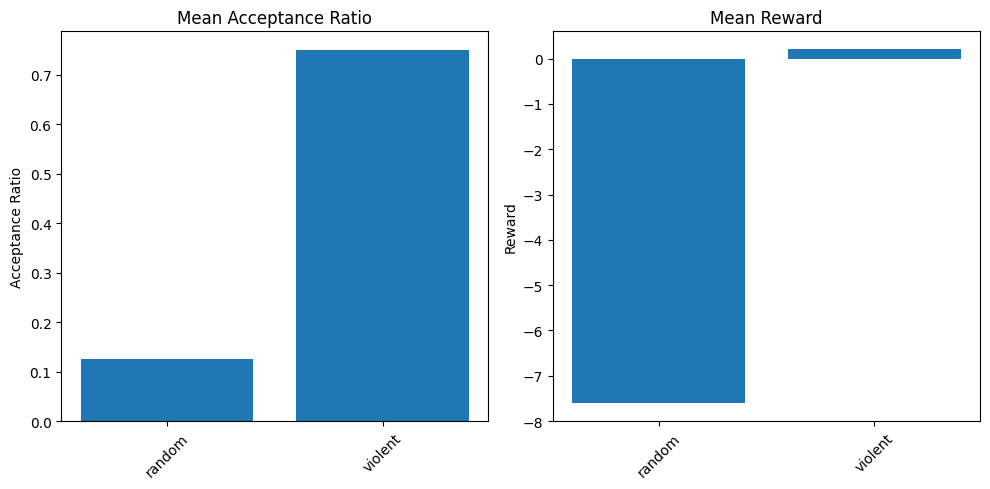

INFO     17:54:14 [sfc_rl_test_data] CSV report saved to outputs/Train-CrossValidation0_20251206_175322/output_eval/evaluation_results.csv
INFO     17:54:14 [sfc_rl_test_data] Experiment completed. Results saved to outputs/Train-CrossValidation0_20251206_175322/output_eval
INFO     17:54:14 [sfc_rl_test_data] Cleaned and removed cache: .vnReqs_cache


In [9]:
from sfc_rl.train.evaluator import Evaluator

eval_cfg = cfg.eval


logger.info("Starting Evaluating...")
evaluator = Evaluator(env,
policies={'random':RandomPolicy(model_cfg.get("seed", 42)),'violent':ExhaustiveSolver( max_embeddings=1000000, seed = model_cfg.get("seed", 42))},
config=eval_cfg, output_dir= output_dir / Path(eval_cfg.get('output_dir','output_eval')),logger = logger)

evaluator.evaluate()

logger.info(f"Experiment completed. Results saved to {output_dir / Path(eval_cfg.get('output_dir','output_eval')) }")
if cache_path.exists() and cache_path.is_dir():
    shutil.rmtree(cache_path)
    logger.info(f"Cleaned and removed cache: {cache_path}")
else:
    logger.info(f"Cache directory not found: {cache_path}")

